# Detectron2 Model Tuning

This notebook picks a Detectron2 model from the model zoo and tunes its hyperparameters on it on a subset of the data (10% of training and 10% of combined validation/test data). 

The model chosen is from the Weights & Biases runs done in previous experiments. 

Original Detectron2 tutorial: https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

+

<img src="https://i.imgur.com/1oTyk79.png" width="500">


# Import Dependencies

In [2]:
import logging
import os
import argparse
from collections import OrderedDict
import pandas as pd
import numpy as np
import torch
from torch.nn.parallel import DistributedDataParallel

import detectron2.utils.comm as comm
from detectron2.checkpoint import DetectionCheckpointer, PeriodicCheckpointer
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import (
    MetadataCatalog,
    build_detection_test_loader,
    build_detection_train_loader,
)
from detectron2.engine import default_argument_parser, default_setup, launch
from detectron2.evaluation import ( ### Changes from original, I don't need all the different evaluators
    COCOEvaluator,
    DatasetEvaluators,
    inference_on_dataset,
    print_csv_format
)
from detectron2.modeling import build_model
from detectron2.solver import build_lr_scheduler, build_optimizer
# Not sure what these do but they may help to track experiments
from detectron2.utils.events import (
    CommonMetricPrinter,
    EventStorage,
    JSONWriter,
    TensorboardXWriter
)

from detectron2.utils.visualizer import Visualizer

# Setup logger
logger = logging.getLogger("detectron2")

In [3]:
# import some common libraries
import cv2
import json
import random
import os
import pandas as pd
import numpy as np
#from google.colab.patches import cv2_imshow
from tqdm import tqdm

# wandb - Import weight's & biases
import wandb

import torch, torchvision
print(torch.__version__)
!gcc --version
# opencv is pre-installed on colab

1.4.0+cu100
gcc (Debian 6.3.0-18+deb9u1) 6.3.0 20170516
Copyright (C) 2016 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [4]:
# What GPU are we using?
!nvidia-smi

Thu Mar 26 06:10:16 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    23W /  75W |      0MiB /  7611MiB |      2%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [5]:
# # wandb - Login to wandb account so all metrics can be logged
# !wandb login

In [6]:
# Initialize Weights & Biases
import wandb
wandb.init(project="airbnb-object-detection", 
           sync_tensorboard=True)

Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


W&B Run: https://app.wandb.ai/mrdbourke/airbnb-object-detection/runs/26711kaj

# Setup paths and target classes

TODO - add annotations

In [7]:
valid_path = "validation"
train_path = "train"
test_path = "test"
train_10_path = "train_10"
val_test_10_path = "val_test_10"
val_test_path = "val_test"

In [8]:
# Classes of amenities Airbnb mostly cares about
subset = ['Toilet',
         'Swimming pool',
         'Bed',
         'Billiard table',
         'Sink',
         'Fountain',
         'Oven',
         'Ceiling fan',
         'Television',
         'Microwave oven',
         'Gas stove',
         'Refrigerator',
         'Kitchen & dining room table',
         'Washing machine',
         'Bathtub',
         'Stairs',
         'Fireplace',
         'Pillow',
         'Mirror',
         'Shower',
         'Couch',
         'Countertop',
         'Coffeemaker',
         'Dishwasher',
         'Sofa bed',
         'Tree house',
         'Towel',
         'Porch',
         'Wine rack',
         'Jacuzzi']

# Put target classes in alphabetical order (required for the labels being generated)
subset.sort()

In [9]:
subset

['Bathtub',
 'Bed',
 'Billiard table',
 'Ceiling fan',
 'Coffeemaker',
 'Couch',
 'Countertop',
 'Dishwasher',
 'Fireplace',
 'Fountain',
 'Gas stove',
 'Jacuzzi',
 'Kitchen & dining room table',
 'Microwave oven',
 'Mirror',
 'Oven',
 'Pillow',
 'Porch',
 'Refrigerator',
 'Shower',
 'Sink',
 'Sofa bed',
 'Stairs',
 'Swimming pool',
 'Television',
 'Toilet',
 'Towel',
 'Tree house',
 'Washing machine',
 'Wine rack']

## Import premade labels

In [10]:
%%time
from preprocessing import load_json_labels

# These require .JSON files to be made in train/validation images folders
val_img_dicts = load_json_labels(val_test_10_path)
train_img_dicts = load_json_labels(train_10_path)

CPU times: user 20 ms, sys: 0 ns, total: 20 ms
Wall time: 20.1 ms


In [11]:
val_img_dicts[0], train_img_dicts[1]

({'file_name': 'val_test_10/9ee4d07829846ff3.jpg',
  'image_id': 0,
  'height': 768,
  'width': 1024,
  'annotations': [{'bbox': [0.0, 348.0, 463.0, 768.0],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 1},
   {'bbox': [304.0, 404.0, 1024.0, 768.0],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 1},
   {'bbox': [653.0, 401.0, 997.0, 647.0],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 16},
   {'bbox': [255.0, 347.0, 458.0, 513.0],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 16},
   {'bbox': [191.0, 353.0, 424.0, 525.0],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 16}]},
 {'file_name': 'train_10/aee43839f58d0d46.jpg',
  'image_id': 1,
  'height': 683,
  'width': 1024,
  'annotations': [{'bbox': [418.0, 370.0, 734.0, 596.0],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 12}]})

# Train on a custom dataset

## plain_train_net.py 

I'm going to write out the plain_train_net.py script verbatim to see what it's doing.

https://github.com/facebookresearch/detectron2/blob/master/tools/plain_train_net.py

I'll leave notes and change it where I need to.

## Register dataset
Before I can train a model I've got to register a dataset in Detectron2 style: https://detectron2.readthedocs.io/tutorials/datasets.html#register-a-dataset

This will leverage my preprocessing functions.

**Note:** Be sure to update the config for new datasets: https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets

In [12]:
# Setup training and validation data paths
train_10_path, val_test_10_path, subset

('train_10',
 'val_test_10',
 ['Bathtub',
  'Bed',
  'Billiard table',
  'Ceiling fan',
  'Coffeemaker',
  'Couch',
  'Countertop',
  'Dishwasher',
  'Fireplace',
  'Fountain',
  'Gas stove',
  'Jacuzzi',
  'Kitchen & dining room table',
  'Microwave oven',
  'Mirror',
  'Oven',
  'Pillow',
  'Porch',
  'Refrigerator',
  'Shower',
  'Sink',
  'Sofa bed',
  'Stairs',
  'Swimming pool',
  'Television',
  'Toilet',
  'Towel',
  'Tree house',
  'Washing machine',
  'Wine rack'])

In [13]:
from detectron2.data import DatasetCatalog, MetadataCatalog

def register_datasets(train_path, valid_path=None, target_classes=None):
  """
  Registers a Detectron2 style dataset from training paths.

  Params
  ------
  train_path (str) : pathname to training data containing training images
  valid_path (str) : pathname to validation data containing validation images
  """
  # TODO - update to accept any kind of path, e.g. not only coffeemaker, maybe could take a dict as input?
  # E.g. {"training": "path/to/training",
  #          "valid": "path/to/valid"}
  for d in [train_path, valid_path]:
    dataset_name = d.split("/")[-1]
    print("Registering: {}".format(dataset_name))
    DatasetCatalog.register(dataset_name, lambda d=d: load_json_labels(d))
    MetadataCatalog.get(dataset_name).set(thing_classes=target_classes)
  return MetadataCatalog.get(dataset_name)

In [14]:
ten_percent_metadata = register_datasets(train_path=train_10_path,
                                         valid_path=val_test_10_path,
                                         target_classes=subset)

Registering: train_10
Registering: val_test_10


In [15]:
# # Check registered dataset
# DatasetCatalog._REGISTERED

In [16]:
# # Remove a certain registered dataset if needed:
# DatasetCatalog._REGISTERED.pop()

## TODO - Visualize dataset

Once you've got a dataset registered with Detectron2 it's a good idea to be able to visualize an image.

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

def visualize_sample(data_dicts, metadata, n=1):
  """
  Show n random samples from data_dicts, label with metadata.
  """
  for d in random.sample(data_dicts, n):
    print(d)
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], 
                            metadata=metadata, 
                            scale=0.3)
    vis = visualizer.draw_dataset_dict(d)
    
#     # Try plot with cv2 in Jupyter... (doesn't work)
#     cv2.imshow('image', vis.get_image()[:, :, ::-1])
#     cv2.waitKey(0) 
#     cv2.destroyWindow('image')
    
    # Try plot with matplotlib (works)
    plt.figure(figsize=(10, 6))
    plt.imshow(vis.get_image()) #[:, :, ::-1])
    plt.xticks([])
    plt.yticks([])
    plt.show()

{'file_name': 'val_test_10/263855bc9c5449cd.jpg', 'image_id': 270, 'height': 1024, 'width': 768, 'annotations': [{'bbox': [119.0, 329.0, 649.0, 888.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 1}, {'bbox': [340.0, 428.0, 557.0, 498.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 16}, {'bbox': [118.0, 464.0, 390.0, 559.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 16}]}


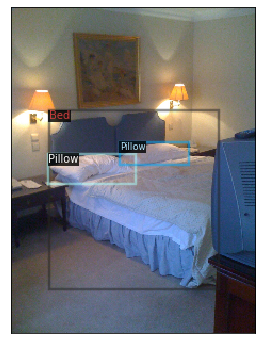

{'file_name': 'val_test_10/54f4b29c1fdd1fd7.jpg', 'image_id': 4, 'height': 683, 'width': 1024, 'annotations': [{'bbox': [307.0, 101.0, 778.0, 630.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 8}]}


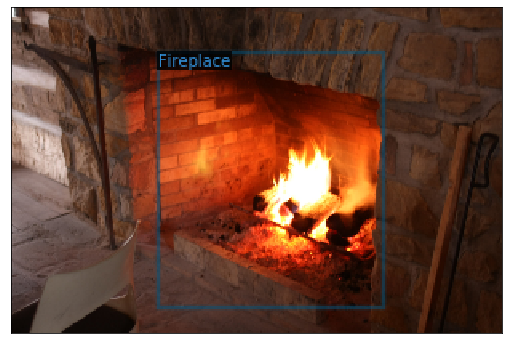

In [30]:
visualize_sample(val_img_dicts, 
                 ten_percent_metadata, 
                 n=2)

## Train

The following code is original training code from the Detectron2 example notebook but I think we can make it better/suit our problem.

In [31]:
# # Example setup of default config
# default_config = get_cfg()
# default_config.DATASETS.TRAIN = ("my-training-data",)
# default_config.DATASETS
# # Set cfg.TEST.EVAL_PERIOD to something to have an evaluation be run every X iterations
# default_config.TEST

In [32]:
# Changed from original: Create evaluator for COCOEvaluator only 
# Since we are only using bounding boxes to begin with, our evaluator can be simple COCO style
def get_evaluator(cfg, dataset_name, output_folder=None):
  """
  Create a COCOEvaluator
  """
  if output_folder is None:
    output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
  evaluator = COCOEvaluator(
      dataset_name=dataset_name,
      cfg=cfg,
      distributed=False,
      output_dir=output_folder
  )
  return evaluator

In [33]:
# Create testing function
def do_test(cfg, model):
  results = OrderedDict()
  for dataset_name in cfg.DATASETS.TEST:
    data_loader = build_detection_test_loader(cfg, dataset_name)
    # Create the evaluator
    evaluator = get_evaluator(
        cfg, 
        dataset_name,
        output_folder=os.path.join(cfg.OUTPUT_DIR, "inference", dataset_name)
    )
    # Make inference on dataset
    results_i = inference_on_dataset(model,
                                     data_loader,
                                     evaluator)
    # Update results dictionary
    results[dataset_name] = results_i

    print("### Returning results_i...")
    #print(results_i)
    #print(f"### Average Precision: {results_i['AP']}")
    # Let's get some communication happening
    if comm.is_main_process():
      logger.info("Evaluation results for {} in csv format:".format(dataset_name))
      ## wandb.log()? TODO/NOTE: This may be something Weights & Biases can track
      #print("### Calculating results...")
      print_csv_format(results_i)
    
    # Check to see length of results
    if len(results) == 1:
      results = list(results.values())[0]
    #print("### Returning results...")
    #print(results)

    # TODO : log results_i dict with different parameters
    print("### Saving results to Weights & Biases...")
    wandb.log(results_i)

    return results

Source code for Checkpointer: https://detectron2.readthedocs.io/_modules/fvcore/common/checkpoint.html

Maybe information from the Checkpointers can be saved to Weights & Biases? Or at least used to track in my own tracking.

In [34]:
# Create training function
def do_train(cfg, model, resume=False):
  # Set model to training mode
  model.train()
  # Create optimizer from config file (returns torch.nn.optimizer.Optimizer)
  optimizer = build_optimizer(cfg, model)
  # Create scheduler for learning rate (returns torch.optim.lr._LR_scheduler)
  scheduler = build_lr_scheduler(cfg, optimizer)
  print(f"Scheduler: {scheduler}")

  # Create checkpointer
  checkpointer = DetectionCheckpointer(
      model, save_dir=cfg.OUTPUT_DIR, optimizer=optimizer, scheduler=scheduler
  )

  # Create start iteration (refernces checkpointer) - https://detectron2.readthedocs.io/modules/checkpoint.html#detectron2.checkpoint.Checkpointer.resume_or_load
  start_iter = (
      # This can be 0
      checkpointer.resume_or_load(cfg.MODEL.WEIGHTS, # Use predefined model weights (pretrained model)
                                  resume=resume).get("iteration", -1) + 1
  )
  # Set max number of iterations
  max_iter = cfg.SOLVER.MAX_ITER

  # Create periodiccheckpoint
  periodic_checkpointer = PeriodicCheckpointer(checkpointer=checkpointer,
                                               # How often to make checkpoints?
                                               period=cfg.SOLVER.CHECKPOINT_PERIOD,
                                               max_iter=max_iter)
  
  # Create writers (for saving checkpoints?)
  writers = (
      [
       # Print out common metrics such as iteration time, ETA, memory, all losses, learning rate
       CommonMetricPrinter(max_iter=max_iter),
       # Write scalars to a JSON file such as loss values, time and more
       JSONWriter(os.path.join(cfg.OUTPUT_DIR, "metrics.json")),
       # Write all scalars such as loss values to a TensorBoard file for easy visualization
       TensorboardXWriter(cfg.OUTPUT_DIR),
      ]
      if comm.is_main_process()
      else []
  )

  ### Original note from script: ###
  # compared to "train_net.py", we do not support accurate timing and precise BN
  # here, because they are not trivial to implement

  # Build a training data loader based off the training dataset name in the config
  data_loader = build_detection_train_loader(cfg)

  # Start logging
  logger.info("Starting training from iteration {}".format(start_iter))

  # Store events
  with EventStorage(start_iter) as storage:
    # Loop through zipped data loader and iteration
    for data, iteration in zip(data_loader, range(start_iter, max_iter)):
      iteration = iteration + 1
      storage.step() # update stroage with step - https://detectron2.readthedocs.io/modules/utils.html#detectron2.utils.events.EventStorage.step

      # Create loss dictionary by trying to model data
      loss_dict = model(data)
      losses = sum(loss_dict.values())
      # Are losses infinite? If so, something is wrong
      assert torch.isfinite(losses).all(), loss_dict

      # TODO - Not quite sure what's happening here
      loss_dict_reduced = {k: v.item() for k, v in comm.reduce_dict(loss_dict).items()}
      # Sum up losses
      losses_reduced = sum(loss for loss in loss_dict_reduced.values())
      
      # # TODO: wandb.log()? log the losses
      # wandb.log({
      #     "Total loss": losses_reduced
      # })

      # Update storage
      if comm.is_main_process():
        # Store informate in storage - https://detectron2.readthedocs.io/modules/utils.html#detectron2.utils.events.EventStorage.put_scalars
        storage.put_scalars(total_loss=losses_reduced,
                            **loss_dict_reduced)
      
      # Start doing PyTorch things
      optimizer.zero_grad()
      losses.backward()
      optimizer.step()
      # Add learning rate to storage information
      storage.put_scalar("lr", optimizer.param_groups[0]["lr"], smoothing_hint=False)
      # This is required for your learning rate to change!!!! (not having this meant my learning rate was staying at 0)
      scheduler.step()

      # Perform evaluation?
      if (
          cfg.TEST.EVAL_PERIOD > 0
          and iteration % cfg.TEST.EVAL_PERIOD == 0
          and iteration != max_iter
      ):
          do_test(cfg, model)
          # TODO - compared to "train_net.py", the test results are not dumped to EventStorage
          comm.synchronize()
      
      # Log different metrics with writers
      if iteration - start_iter > 5 and (iteration % 20 == 0 or iteration == max_iter):
        for writer in writers:
          writer.write()
      
      # Update the periodic_checkpointer
      periodic_checkpointer.step(iteration)

In [35]:
# Create setup function
def setup(args):
  """
  Create configs and perform basic setups.
  """
  cfg = get_cfg()
  cfg.merge_from_file(args.config_file) # This will take some kind of model.yaml file
  cfg.merge_from_list(args.opts)
  cfg.freeze()
  default_setup(
      cfg, args
  ) # this logs the config and arguments passed to the command line to the output file

  # Load config YAML as dict
  cfg_yaml = cfg.load_yaml_with_base(os.path.join(cfg.OUTPUT_DIR, "config.yaml"))

  # default_config = get_cfg()
  # default_config_loaded = default_config.load_yaml_with_base("output/config.yaml")
  # default_config_loaded

  # TODO: turn config into YAML and save to weights & biases
  # TODO: Init wandb and add configs
  # Setup a new weights & biases run every time we run the setup() function
  wandb.init(project="airbnb-object-detection", 
             sync_tensorboard=True)
  
  #print("### Printing config_yaml file to go into Weights & Biases")
  #print(cfg_yaml)
  wandb.config.update(cfg_yaml)

  return cfg

In [37]:
# Create main function
def main(args):
  
  # Create the config file
  cfg = setup(args)

  # Build the model
  model = build_model(cfg)
  
  # Log what's going on
  logger.info("Model:\n{}".format(model))

  # TODO: Fix this (if it doesn't work)
  #wandb.watch(model, log="all")

  # Only do evaluation if the args say so
  if args.eval_only:
    DetectionCheckpointer(model, save_dir=cfg.OUTPUT_DIR).resume_or_load(
        cfg.MODEL.WEIGHTS, resume=args.resume
    )
    return do_test(cfg, model)

  # Do distributed training? (depends on number of GPUs available)
  distributed = comm.get_world_size() > 1
  if distributed:
    # Put the model on multiple devices if available
    model = DistributedDataParallel(
        model, 
        device_ids=[comm.get_local_rank()], 
        broadcast_buffers=False
    )

  # Train the model
  do_train(cfg, model)
  # TODO - May want to evaluate in a different step?
  return do_test(cfg, model)

## TODO: Setup different experiments for `models_to_try`

Let's use a MAX_ITER of ~30 whilst we're building a small model.

We'll also change some defaults:
* `SOLVER.IMS_PER_BATCH` = 16 -> 2 (lower for memory issues)
* `DATALOADER.NUM_WORKERS` = 4 -> 2 (lower for memory issues)

These lowering settings are based on the example Detectron2 tutorial notebook (which runs in Colab), we can update them later once we figure out what resources we're using.

See this post for an example of resource use: https://lambdalabs.com/blog/weights-and-bias-gpu-cpu-utilization/

In [55]:
# Different models I'd like to try - https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md
models_to_try = {
    #"RN-R50-1x": "COCO-Detection/retinanet_R_50_FPN_1x.yaml",
    #"RN-R50-3x": "COCO-Detection/retinanet_R_50_FPN_3x.yaml",
    "RN-R101-3x": "COCO-Detection/retinanet_R_101_FPN_3x.yaml"
}

In [56]:
# Setup arg parser
parser = default_argument_parser() # default in Detectron2

In [57]:
# Setup different weights and config files to try
weights = []
configs = []
for k, v in models_to_try.items():
  model = models_to_try[k]
  model_weights = model_zoo.get_checkpoint_url(model)
  weights.append(model_weights)
  config_file = model_zoo.get_config_file(model)
  configs.append(config_file)
weights_configs = dict(zip(weights, configs))
weights_configs

{'https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/retinanet_R_101_FPN_3x/138363263/model_final_59f53c.pkl': '/opt/anaconda3/lib/python3.7/site-packages/detectron2/model_zoo/configs/COCO-Detection/retinanet_R_101_FPN_3x.yaml'}

In [58]:
# Setup different arg strings to pass to main() 
workers = 8
ims_per_batch = 2
lr = 0.00025
max_iter = 5000
seed = 33
num_classes = len(subset)
eval_period = 500 # how often to evaluate the data (number of steps, usual is to do at the end of all training)

arg_strings = []
for weights, config in weights_configs.items():
  arg_string = f"--config-file {config} \
                MODEL.WEIGHTS {weights} \
                DATASETS.TRAIN ('train_10',) \
                DATASETS.TEST ('val_test_10',) \
                DATALOADER.NUM_WORKERS {workers} \
                SOLVER.IMS_PER_BATCH {ims_per_batch} \
                SOLVER.BASE_LR {lr} \
                SOLVER.MAX_ITER {max_iter} \
                SEED {seed} \
                TEST.EVAL_PERIOD {eval_period} \
                MODEL.ROI_HEADS.NUM_CLASSES {num_classes}".split()
  arg_strings.append(arg_string)

In [59]:
# Create different arg parsers
arg_list = []
for arg_string in arg_strings:
  args = parser.parse_args(arg_string)
  print(args)
  arg_list.append(args)

Namespace(config_file='/opt/anaconda3/lib/python3.7/site-packages/detectron2/model_zoo/configs/COCO-Detection/retinanet_R_101_FPN_3x.yaml', dist_url='tcp://127.0.0.1:50152', eval_only=False, machine_rank=0, num_gpus=1, num_machines=1, opts=['MODEL.WEIGHTS', 'https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/retinanet_R_101_FPN_3x/138363263/model_final_59f53c.pkl', 'DATASETS.TRAIN', "('train_10',)", 'DATASETS.TEST', "('val_test_10',)", 'DATALOADER.NUM_WORKERS', '8', 'SOLVER.IMS_PER_BATCH', '2', 'SOLVER.BASE_LR', '0.00025', 'SOLVER.MAX_ITER', '5000', 'SEED', '33', 'TEST.EVAL_PERIOD', '500', 'MODEL.ROI_HEADS.NUM_CLASSES', '30'], resume=False)


## Run custom training loop

In [60]:
for i, namespace in enumerate(arg_list):
  print(f"Running experiment: {i}") # derp......
  main(namespace)

Running experiment: 0
WARNING [03/26 08:15:57 fvcore.common.config]: Loading config /opt/anaconda3/lib/python3.7/site-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.
[03/26 08:15:57 detectron2]: Rank of current process: 0. World size: 1
[03/26 08:15:57 detectron2]: Environment info:
------------------------  -------------------------------------------------------------------
sys.platform              linux
Python                    3.7.4 (default, Aug 13 2019, 20:35:49) [GCC 7.3.0]
numpy                     1.17.4
detectron2                0.1.1 @/opt/anaconda3/lib/python3.7/site-packages/detectron2
detectron2 compiler       GCC 7.3
detectron2 CUDA compiler  10.0
detectron2 arch flags     sm_35, sm_37, sm_50, sm_52, sm_60, sm_61, sm_70, sm_75
DETECTRON2_ENV_MODULE     <not set>
PyTorch                   1.4.0+cu100 @/opt/anaconda3/lib/python3.7/site-packages/torch
PyTo

Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


[03/26 08:16:04 detectron2]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequen

## TODO - Draw predictions

In [ ]:
import detectron2
# Load in config file
loaded_cfg = get_cfg()
loaded_cfg = loaded_cfg.load_yaml_with_base(os.path.join(loaded_cfg.OUTPUT_DIR, "config.yaml"))
loaded_cfg = detectron2.config.CfgNode(loaded_cfg)
# loaded_cfg

In [ ]:
loaded_cfg["MODEL"]["ROI_HEADS"]["SCORE_THRESH_TEST"]

0.05

In [ ]:
from detectron2.engine import DefaultPredictor
# Setup predictor
loaded_cfg["MODEL"]["WEIGHTS"] = os.path.join(loaded_cfg["OUTPUT_DIR"], "model_final.pth")
loaded_cfg["MODEL"]["ROI_HEADS"]["SCORE_THRESH_TEST"] = 0.7   # set the testing threshold for this model
loaded_cfg["DATASETS"]["TEST"] = ("cmaker-bathtub-treehouse-validation", )
predictor = DefaultPredictor(loaded_cfg)

[03/18 06:09:17 fvcore.common.checkpoint]: Loading checkpoint from ./output/model_final.pth


{'instances': Instances(num_instances=2, image_height=768, image_width=1024, fields=[pred_boxes: Boxes(tensor([[ 332.9039,  238.9931, 1021.1638,  768.0000],
        [  75.1831,  523.6356,  566.5775,  768.0000]], device='cuda:0')), scores: tensor([0.8273, 0.7050], device='cuda:0'), pred_classes: tensor([0, 0], device='cuda:0')])}


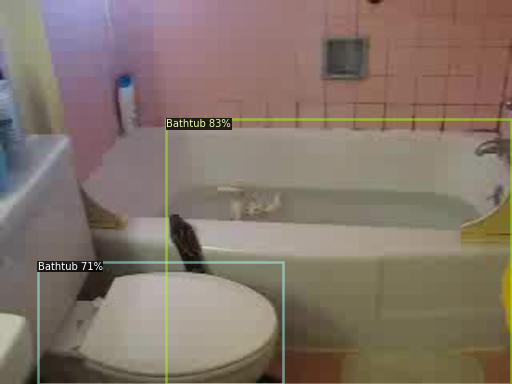

In [ ]:
from detectron2.utils.visualizer import ColorMode
#dataset_dicts = get_balloon_dicts("balloon/val")
for d in random.sample(val_img_dicts, 1):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    print(outputs)
    v = Visualizer(im[:, :, ::-1],
                   metadata=cmaker_bathtub_metadata, 
                   scale=0.5 
                   #instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])